<a href="https://colab.research.google.com/github/gPwls1025/DSGA-1007-Final-Project/blob/main/code/DSGA1007_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

#load data from github
total_Life_expectancy_at_birth=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_Life_expectancy_at_birth.csv')
total_birth_rate=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_birth_rate.csv')
total_death_rate=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_death_rate.csv')
total_fertility_rate=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_fertility_rate.csv')
total_population=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_population.csv')
total_median_age=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_median_age.csv')
total_population_growth=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/total_population_growth.csv')
all_indicators = pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/all_indicators.csv')
population_dependent=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/Dependent_Population.csv')
countries_group_all=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/country_groups_all.csv')
countries_region=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/Dependent_Population_Region.csv')
world_bank_data=pd.read_csv('https://raw.githubusercontent.com/gPwls1025/DSGA-1007-Final-Project/main/data/Income%20Group%20by%20Country_World%20Bank.csv')
plt.style.use('default')

## Clean and Explore data

In [ ]:
#check if there is any missing value
all_indicators.isnull().sum()

economy            0
Pop-YR2002         0
Pop-YR2021         0
Pop%               1
Life-YR2002        0
Life-YR2021        0
Life%              8
Fer-YR2002         0
Fer-YR2021         0
Fer%               8
Death-YR2002       0
Death-YR2021       0
Death%             6
Birth-YR2002       0
Birth-YR2021       0
Birth%             5
Med_Age-YR2002    43
Med_Age-YR2021    43
Med%              43
Pop_Gro-YR2002     0
Pop_Gro-YR2021     0
dtype: int64

In [ ]:
#drop "INX" - no population data
all_indicators = all_indicators[all_indicators['economy']!= 'INX']

MNP, ASM, PLW, AND, MCO, SMR, CYM -> No data collected for Life expectancy and fertility (exclude these countries from analysis on LE and FE)

MNP, ASM, AND, MCO, SMR -> No death rate data (Exclude from analysis on death rate)

MNP, ASM, MCO, SMR -> No birth rate data

43 countries with no median age data -> we won't be replacing missing values with anything (leave it as null)

In [ ]:
#Looking at general stats from columns Pop-YR2002 to Pop_Gro-YR2021
all_indicators.describe().T.style.background_gradient(cmap='YlOrBr')

,count,mean,std,min,25%,50%,75%,max
Pop-YR2002,265.000000,252798399.256604,800698111.351100,9609.000000,1341696.000000,8372306.000000,51662071.000000,6308140970.000000
Pop-YR2021,265.000000,322516710.603774,1004210387.962170,11204.000000,1786038.000000,10505772.000000,63588334.000000,7888161297.000000
Pop%,265.000000,0.323239,0.334888,-0.358739,0.103062,0.250473,0.522931,2.769332
Life-YR2002,265.000000,65.746363,14.344607,0.000000,59.534000,69.976592,74.612000,81.690732
Life-YR2021,265.000000,69.219389,14.271641,0.000000,65.267000,71.815000,76.399000,85.492683
Life%,258.000000,0.060680,0.094779,-1.000000,0.020812,0.047766,0.088396,0.332119
Fer-YR2002,265.000000,3.054124,1.716568,0.000000,1.753000,2.559000,4.125000,7.671000
Fer-YR2021,265.000000,2.475029,1.281463,0.000000,1.570000,2.029000,3.237000,6.820000
Fer%,258.000000,-0.146049,0.185115,-0.540936,-0.258268,-0.177832,-0.071059,0.660000
Death-YR2002,265.000000,8.662918,3.791152,0.000000,5.975000,8.300000,11.035056,18.670000


<ipython-input-5-bce98a1be36b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = all_indicators.corr()


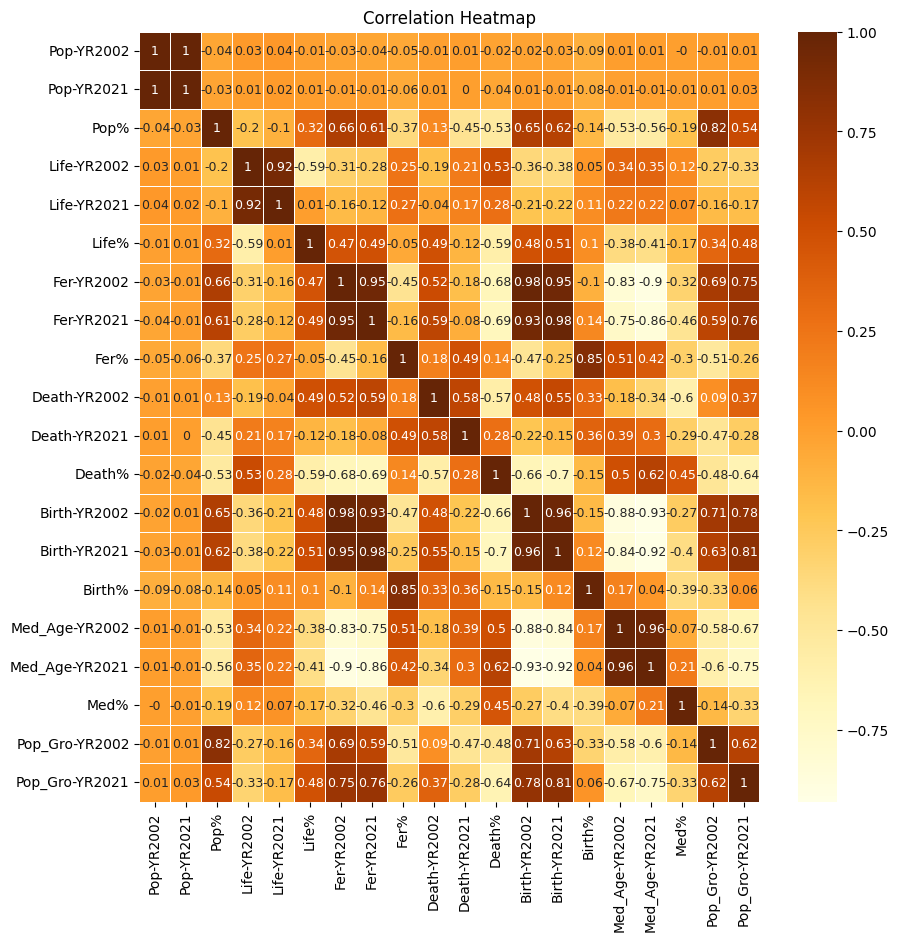

In [ ]:
# Calculate the correlation matrix
correlation_matrix = all_indicators.corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='YlOrBr', linewidths=0.5, annot_kws={"size": 9})
plt.title('Correlation Heatmap')
plt.show()

# Global Level Analysis

In [ ]:
#include countries counted for population
#not filtering will have population results much higher than what was estimated
#https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

countries_group_all=countries_group_all.merge(
    population_dependent,
    left_on='Country',
    right_on='Country_Dependency')

countries=countries_group_all.merge(
    population_dependent,
    left_on='Country',
    right_on='Country_Dependency')[['id','Country']].drop_duplicates()
total_population=total_population.merge(countries,left_on='economy',right_on='id',how='inner')
pop_years_agg=total_population.sum(axis=0,numeric_only=True)
years_index=list(pop_years_agg.index)
years=[int(re.sub('YR','',y)) for y in years_index]

#regions
regions=population_dependent.merge(countries_region,
                                   left_on='Country_Dependency',
                                   right_on='Country')[['Country_Dependency','Region']].merge(countries_group_all[['Country','id']],
                                                                                              left_on='Country_Dependency',
                                                                                              right_on='Country')[['id','Country','Region']].drop_duplicates();

In [ ]:
#functions
def agg_results(df,tp=total_population):
    df_filtered=countries.merge(df,left_on='id',right_on='economy',how='inner')
    results=[sum(df_filtered[y]*(tp[y]/pop_years_agg[y])) for y in years_index]
    return(results)

def subregion_stats(grp_df,grp,var_df,var):
  new_df=grp_df.merge(var_df[['economy','YR2019']],on='economy',how='inner')
  new_var=grp+'_'+var
  grp_var=grp+'_pop%'
  new_df=new_df.assign(**{new_var:lambda x: x['YR2019']*x[grp_var]}).groupby(grp)[new_var].sum().reset_index()
  return(new_df)

def yearly_population_change(df, region_column='Region', year_column_prefix='YR'):
    """Calculate the yearly population change for each region"""
    year_columns = [col for col in df.columns if col.startswith(year_column_prefix)]
    df_yearly_change = pd.DataFrame()

    for i in range(len(year_columns)-1):
        year = int(year_columns[i][len(year_column_prefix):])
        next_year = int(year_columns[i+1][len(year_column_prefix):])
        change_column = f'Change_{year}_{next_year}'

        df_yearly_change[change_column] = df[year_columns[i+1]] - df[year_columns[i]]
        df_yearly_change[region_column] = df[region_column]

    return df_yearly_change

def plot_birth_death_rates(region, birth_df, death_df,grp='Region'):
    plt.figure(figsize=(8, 4))
    region_birth_rates = birth_df[(birth_df[grp] == region) & (birth_df['Year'].between(2000, 2021))]
    region_death_rates = death_df[(death_df[grp] == region) & (death_df['Year'].between(2000, 2021))]

    plt.plot(region_birth_rates['Year'], region_birth_rates['Birth Rate'], label='Birth Rate')
    plt.plot(region_death_rates['Year'], region_death_rates['Death Rate'], label='Death Rate')

    plt.title(f'{region} - Birth and Death Rates (2000-2021)')
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()



Visualize the changes of overall populations from 2000-2001

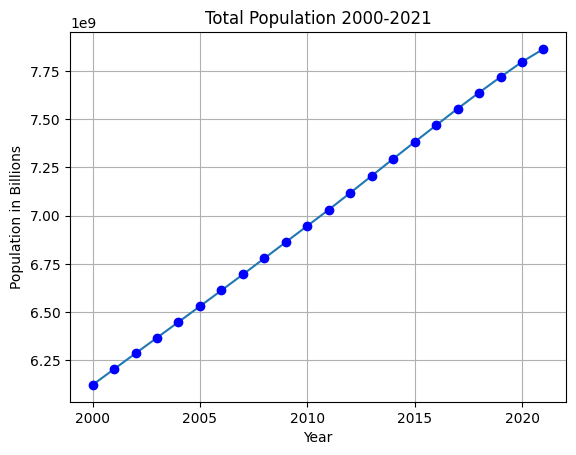

In [ ]:
#overall population change
pop_years_agg=total_population.sum(axis=0,numeric_only=True)
years=[int(re.sub('YR','',y)) for y in list(pop_years_agg.index)]
plt.plot(years, pop_years_agg)
plt.plot(years, pop_years_agg,'bo')
plt.xlabel('Year')
plt.ylabel('Population in Billions')
plt.title('Total Population 2000-2021')
plt.grid();

Visualize changes of different indicators from 2000-2001

In [ ]:
#global trends
results_agg=[agg_results(total_birth_rate),
agg_results(total_death_rate),
agg_results(total_fertility_rate),
agg_results(total_population_growth)]
title=['Global Birth Rate','Global Death Rate','Global Fertility Rate','Global Population Growth Rate']
yaxis=['Births per 1000 People','Deaths per 1000 People','Births per Woman','% of Growth']
colors=['blue','red','gold','green']

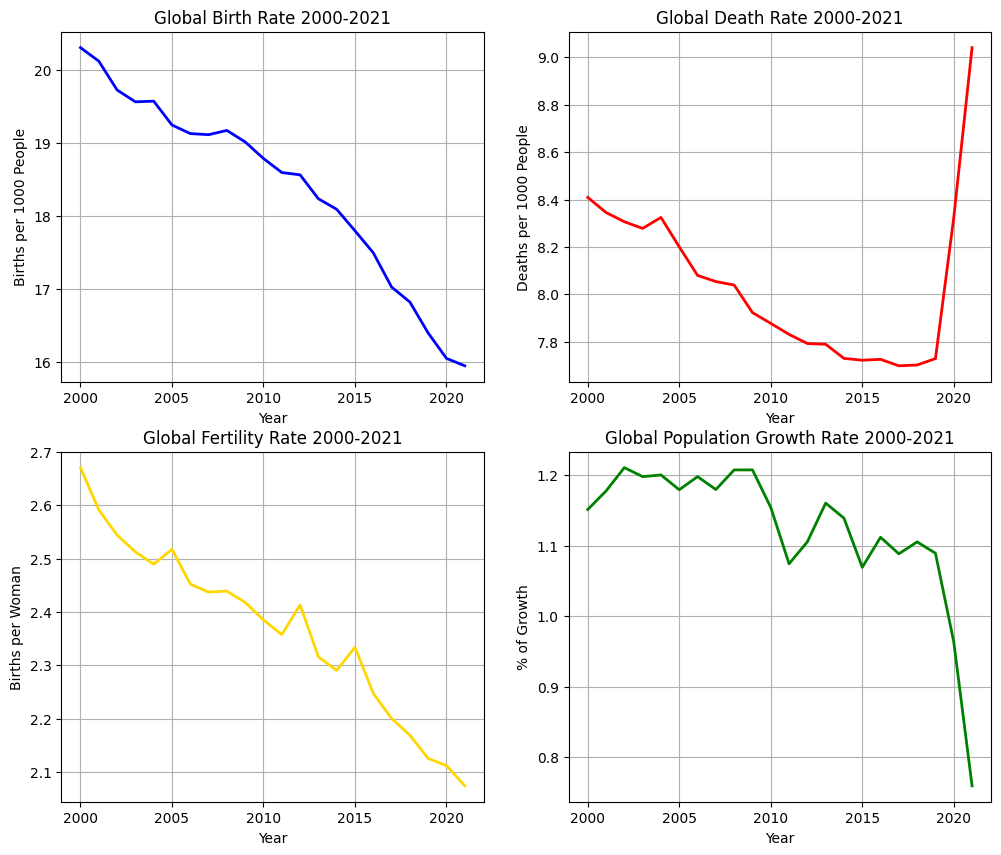

In [ ]:
fig, axs1 = plt.subplots(2, 2, figsize=(12, 10))
for i,n in enumerate(results_agg):
  axs1.flat[i].plot(years,n,color=colors[i],linewidth=2)
  axs1.flat[i].set_ylabel(yaxis[i])
  axs1.flat[i].set_xlabel('Year')
  axs1.flat[i].set_title(title[i]+' 2000-2021')
  axs1.flat[i].grid()
plt.show()

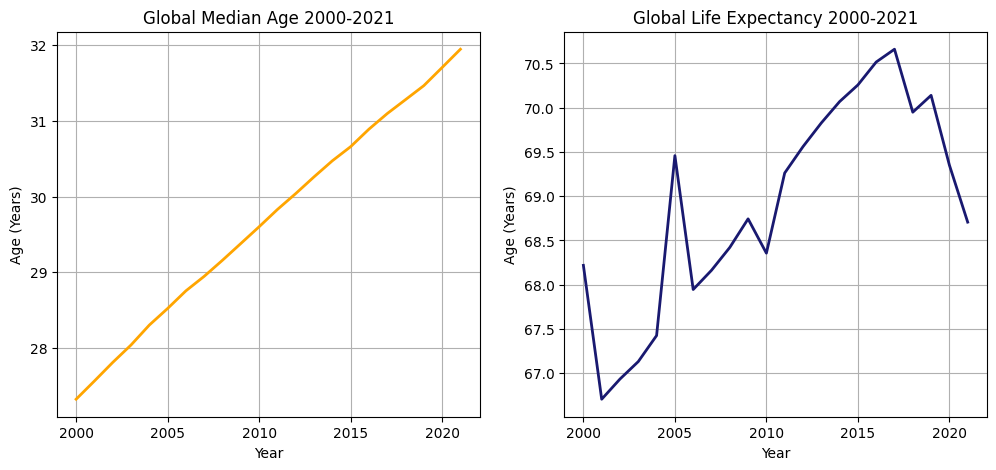

In [ ]:
results_agg_1=[agg_results(total_median_age),agg_results(total_Life_expectancy_at_birth)]
title=['Global Median Age','Global Life Expectancy','Global Fertility Rate','Total Population Growth Rate']
colors=['orange','midnightblue']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i,n in enumerate(results_agg_1):
  axs.flat[i].plot(years,n,color=colors[i],linewidth=2)
  axs.flat[i].set_ylabel('Age (Years)')
  axs.flat[i].set_xlabel('Year')
  axs.flat[i].set_title(title[i]+' 2000-2021')
  axs.flat[i].grid()
plt.show()


# Sub-level Analysis: Region

## Rate changes by region in 2019

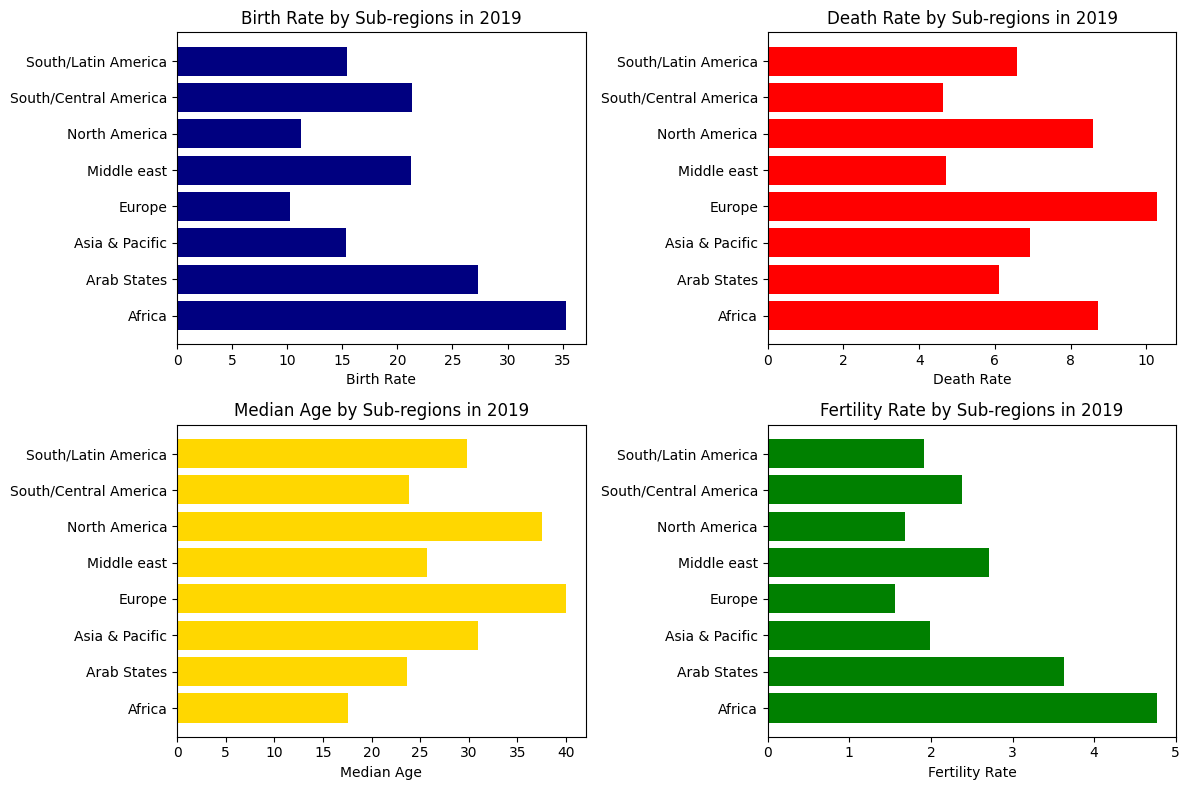

In [ ]:
## start work on subregions, decided on 2019 since 2020-2021 are outliers
#region
region_pop_2019=total_population.merge(regions,left_on='economy',right_on='id')[['economy','Region','YR2019']]
region_pop_2019.columns=['economy','Region','pop']
region_pop_2019['Region_pop']=region_pop_2019.groupby('Region')['pop'].transform('sum')
region_pop_2019['Region_pop%']=region_pop_2019['pop']/region_pop_2019['Region_pop']

reg_birth=subregion_stats(region_pop_2019,'Region',total_birth_rate,'Birth Rate')
reg_death=subregion_stats(region_pop_2019,'Region',total_death_rate,'Death Rate')
reg_med_age=subregion_stats(region_pop_2019,'Region',total_median_age,'Median Age')
reg_fert=subregion_stats(region_pop_2019,'Region',total_fertility_rate,'Fertility Rate')
results_reg=[reg_birth,reg_death,reg_fert,reg_med_age]


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# Plot Birth Rate
axs[0, 0].barh(reg_birth['Region'], reg_birth['Region_Birth Rate'],color='navy')
axs[0, 0].set_title('Birth Rate by Sub-regions in 2019')
axs[0, 0].set_xlabel('Birth Rate')

# Plot Death Rate
axs[0, 1].barh(reg_death['Region'], reg_death['Region_Death Rate'],color='red')
axs[0, 1].set_title('Death Rate by Sub-regions in 2019')
axs[0, 1].set_xlabel('Death Rate')

# Plot Median Age
axs[1, 0].barh(reg_med_age['Region'], reg_med_age['Region_Median Age'],color='gold')
axs[1, 0].set_title('Median Age by Sub-regions in 2019')
axs[1, 0].set_xlabel('Median Age')

# Plot Fertility Rate
axs[1, 1].barh(reg_fert['Region'], reg_fert['Region_Fertility Rate'],color='green')
axs[1, 1].set_title('Fertility Rate by Sub-regions in 2019')
axs[1, 1].set_xlabel('Fertility Rate')

#adjust layout for readability
plt.tight_layout()
plt.show()

##Birth and Death Rate changes by Sub-Regions

In [ ]:
def aggregate_rates_by_year_and_region(rate_df, region_df, rate_var,grp='Region'):
    #melting the rate DataFrame to long format
    rate_df_yearly = rate_df.melt(id_vars=['economy'], var_name='Year', value_name=rate_var)
    rate_df_yearly['Year'] = rate_df_yearly['Year'].str.extract('(\d+)').astype(int)

    region_df_yearly = region_df.melt(id_vars=['economy', grp], var_name='Year', value_name='Population')
    region_df_yearly['Year'] = region_df_yearly['Year'].str.extract('(\d+)').astype(int)
    rate_df_yearly = rate_df_yearly.merge(region_df_yearly[['economy', 'Year', grp]], on=['economy', 'Year'])

    rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()
    return rate_df_yearly

#recreated region_pop instead of using region_pop_2019 since there could be potential changes in region classification over the years
region_pop=total_population.merge(regions,left_on='economy',right_on='id')[['economy','Region', 'YR2000','YR2001','YR2002','YR2003','YR2004',
                                                                            'YR2005','YR2006','YR2007','YR2008','YR2009','YR2010','YR2011',
                                                                            'YR2012','YR2013','YR2014','YR2015','YR2016','YR2017','YR2018',
                                                                            'YR2019','YR2020','YR2021']]

birth_rates_by_region = aggregate_rates_by_year_and_region(total_birth_rate, region_pop, 'Birth Rate')
death_rates_by_region = aggregate_rates_by_year_and_region(total_death_rate, region_pop, 'Death Rate')

<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()
<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()


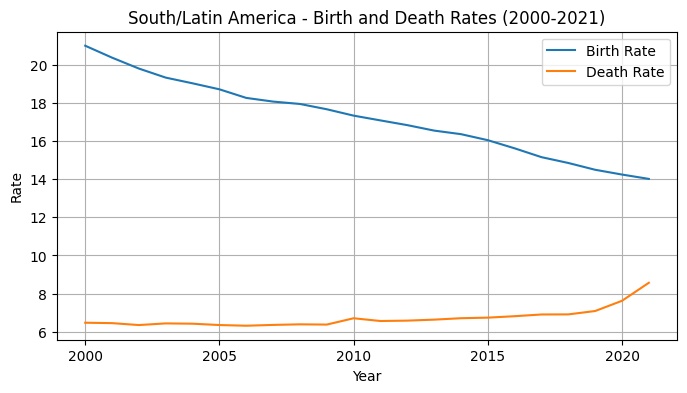

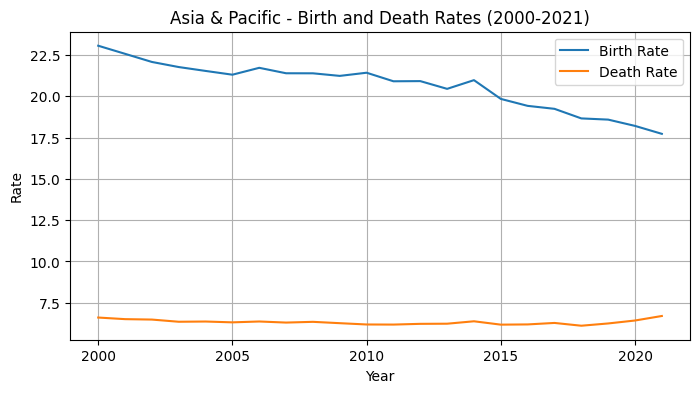

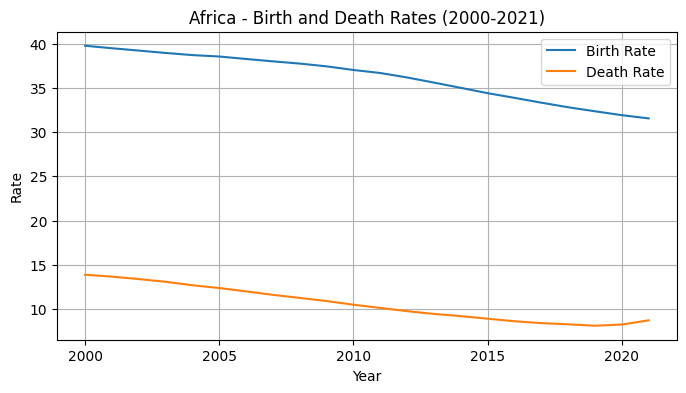

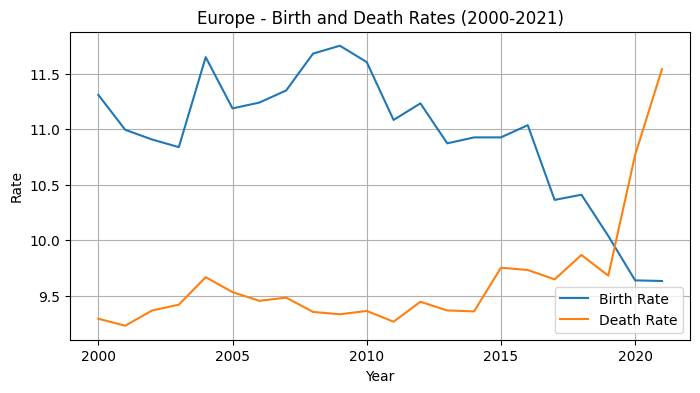

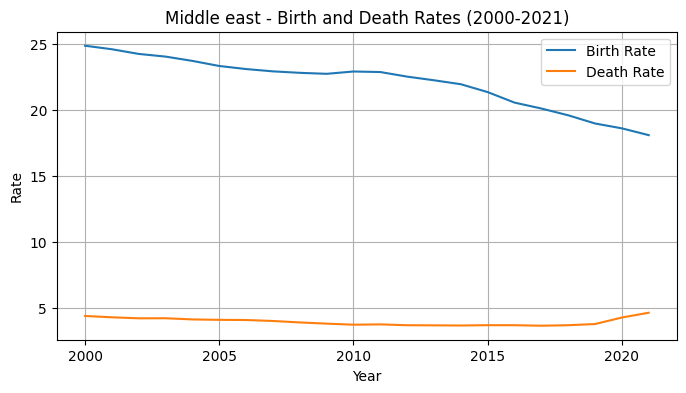

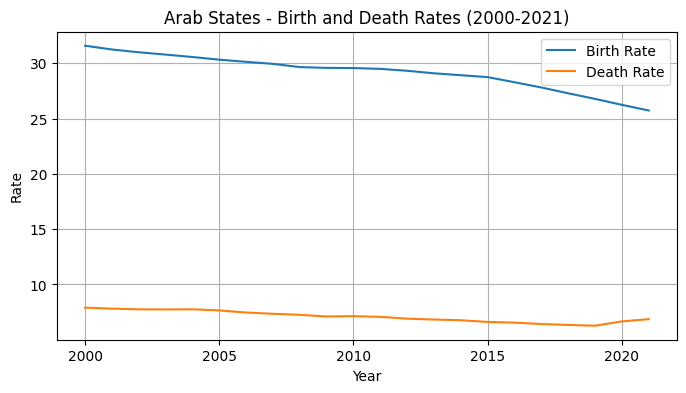

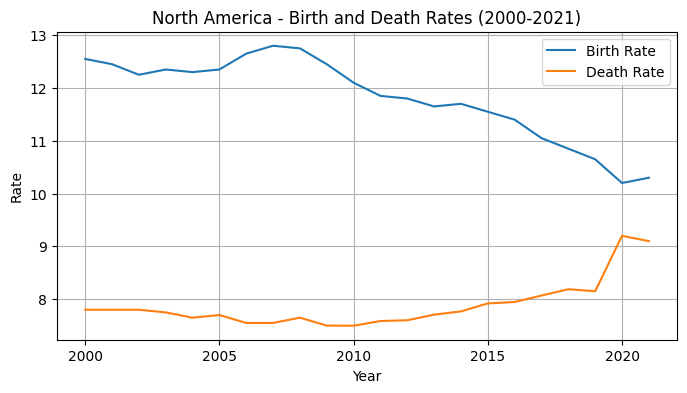

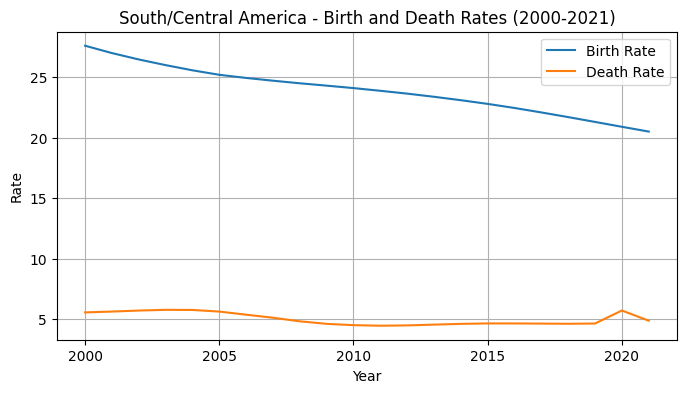

In [ ]:
# Plot for Europe and Africa from 2001 to 2021

#get unique regions
unique_regions = region_pop['Region'].unique()

for region in unique_regions:
    plot_birth_death_rates(region, birth_rates_by_region, death_rates_by_region)

##Population Grouth changes by region

<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()


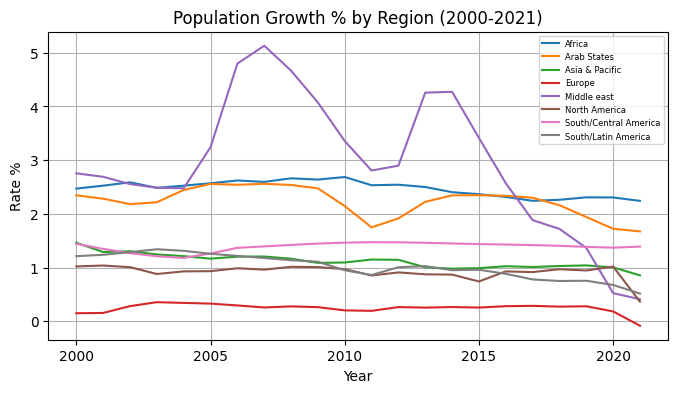

In [ ]:
#trends by Region
pop_growth_by_region = aggregate_rates_by_year_and_region(total_population_growth, region_pop, 'Population Growth Rate')
reg=pop_growth_by_region['Region'].unique()
plt.figure(figsize=(8, 4))
for r in reg:
  region_pop_growth = pop_growth_by_region[(pop_growth_by_region['Region'] == r) & (pop_growth_by_region['Year'].between(2000, 2021))]
  plt.plot(region_pop_growth['Year'], region_pop_growth['Population Growth Rate'], label=r)

plt.title('Population Growth % by Region (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Rate %')
plt.legend(fontsize='6')
plt.grid(True)
plt.show()

### Population change by region

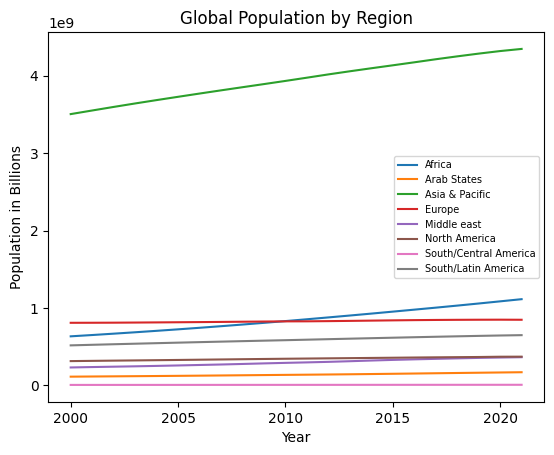

In [ ]:
region_change_pop=pd.wide_to_long(region_pop,['YR'],i='economy',j='year').groupby(['Region','year'])['YR'].sum().reset_index()
for r in reg:
  region_change_pop_grp=region_change_pop[region_change_pop['Region']==r]
  plt.plot(region_change_pop_grp['year'],region_change_pop_grp['YR'],label=r)
plt.legend(fontsize='7')
plt.title('Global Population by Region')
plt.xlabel('Year')
plt.ylabel('Population in Billions');

# Sub-level Analysis: Income Group

In [ ]:
#How Developed the Region is?
income_pop_2019=total_population.merge(world_bank_data,left_on='economy',right_on='Code',how='inner')[['economy','Income group','YR2019']]
income_pop_2019.columns=['economy','Income group','pop']
income_pop_2019['Income group_pop']=income_pop_2019.groupby('Income group')['pop'].transform('sum')
income_pop_2019['Income group_pop%']=income_pop_2019['pop']/income_pop_2019['Income group_pop']
income_birth=subregion_stats(income_pop_2019,'Income group',total_birth_rate,'Birth Rate')
income_death=subregion_stats(income_pop_2019,'Income group',total_death_rate,'Death Rate')
income_med_age=subregion_stats(income_pop_2019,'Income group',total_median_age,'Median Age')
income_fert=subregion_stats(income_pop_2019,'Income group',total_fertility_rate,'Median Age')
results_income=[income_birth,income_death,income_med_age,income_fert]

income_group=['High income','Upper middle income','Lower middle income','Low income']

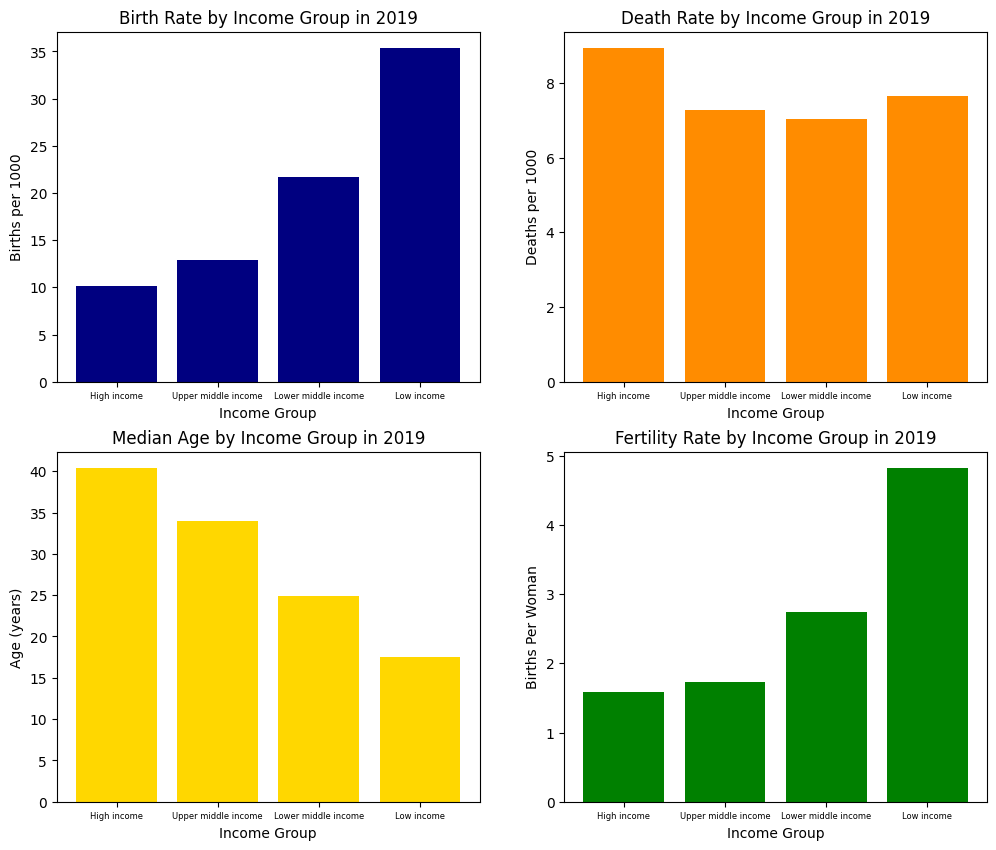

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# Assuming 'Income group' is a column in a DataFrame
colors=['navy','DarkOrange','Gold','green']
title=['Birth Rate','Death Rate','Median Age','Fertility Rate']
y=['Births per 1000','Deaths per 1000','Age (years)','Births Per Woman']

for i,r in enumerate(results_income):
  r['Income group'] = pd.Categorical(r['Income group'],
                                    categories=income_group,
                                     ordered=True)
  r = r.sort_values('Income group')
  axs.flat[i].bar(r['Income group'],r[r.columns[1]],color=colors[i])
  axs.flat[i].tick_params(axis='x',labelsize=6)
  axs.flat[i].set_title(title[i]+' by Income Group in 2019')
  axs.flat[i].set_xlabel('Income Group')
  axs.flat[i].set_ylabel(y[i])

<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()
<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()


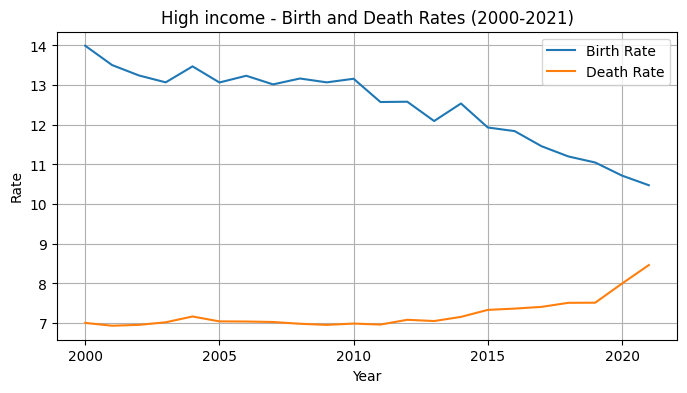

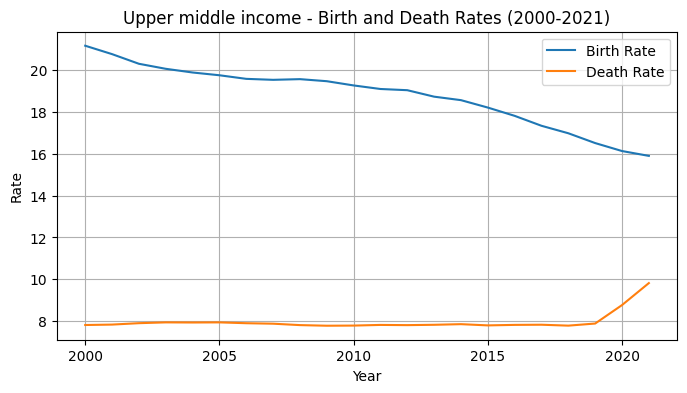

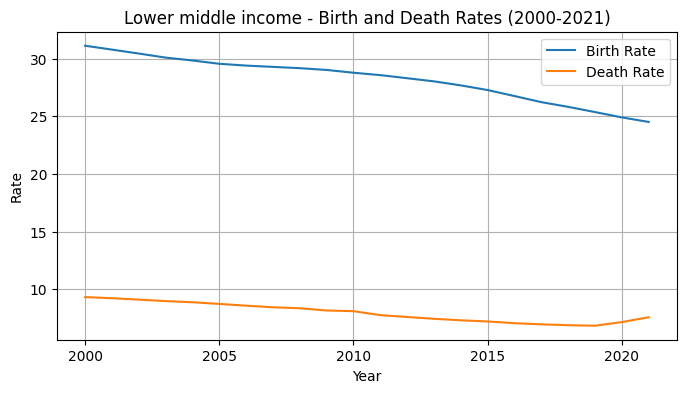

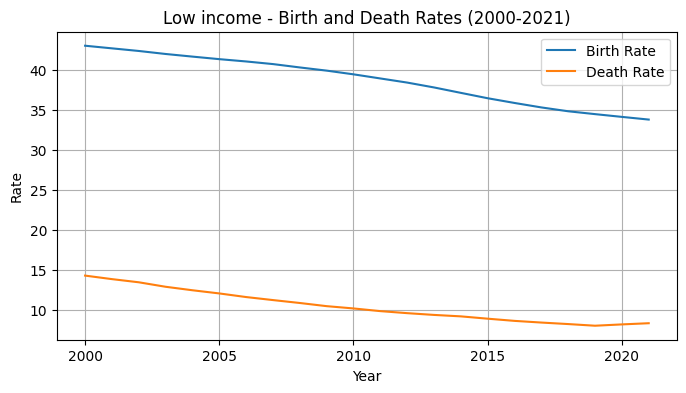

In [ ]:
#birth rate vs death rate by income group
income_pop=total_population.merge(world_bank_data,left_on='economy',right_on='Code')[['economy','Income group', 'YR2000','YR2001','YR2002','YR2003','YR2004',
                                                                            'YR2005','YR2006','YR2007','YR2008','YR2009','YR2010','YR2011',
                                                                            'YR2012','YR2013','YR2014','YR2015','YR2016','YR2017','YR2018',
                                                                            'YR2019','YR2020','YR2021']]

birth_rates_by_income = aggregate_rates_by_year_and_region(total_birth_rate, income_pop, 'Birth Rate','Income group')
death_rates_by_income = aggregate_rates_by_year_and_region(total_death_rate, income_pop, 'Death Rate','Income group')
for inc in income_group:
    plot_birth_death_rates(inc, birth_rates_by_income, death_rates_by_income,grp='Income group')

<ipython-input-14-157d7f0ccb94>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rate_df_yearly = rate_df_yearly.groupby([grp, 'Year']).mean().reset_index()


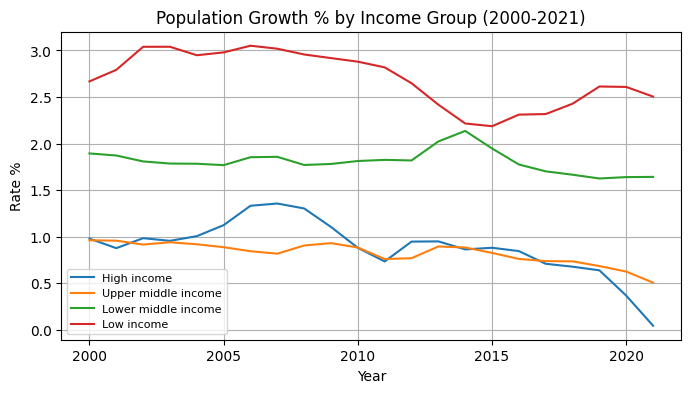

In [ ]:
pop_growth_by_income = aggregate_rates_by_year_and_region(total_population_growth, income_pop, 'Population Growth Rate',grp='Income group')
plt.figure(figsize=(8, 4))
for inc in income_group:
  income_pop_growth = pop_growth_by_income[(pop_growth_by_income['Income group'] == inc) & (pop_growth_by_income['Year'].between(2000, 2021))]
  plt.plot(income_pop_growth['Year'], income_pop_growth['Population Growth Rate'], label=inc)
  plt.legend()
plt.title('Population Growth % by Income Group (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Rate %')
plt.legend(fontsize="8")
plt.grid(True)

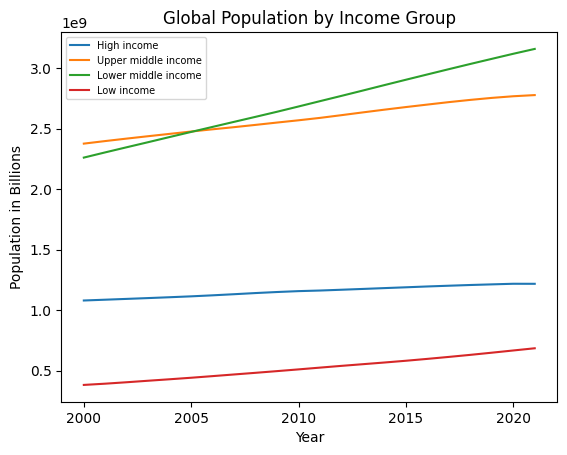

In [ ]:
#population change
income_change_pop=pd.wide_to_long(income_pop,['YR'],i='economy',j='year').groupby(['Income group','year'])['YR'].sum().reset_index()
income_change_pop

for inc in income_group:
  income_change_pop_grp=income_change_pop[income_change_pop['Income group']==inc]
  plt.plot(income_change_pop_grp['year'],income_change_pop_grp['YR'],label=inc)
plt.legend(fontsize='7',loc ="upper left")
plt.title('Global Population by Income Group')
plt.xlabel('Year')
plt.ylabel('Population in Billions');

#Time Series: Forecasting population growth rate in the next 5 years using AutoRegressive (AR)

In [ ]:
#convert the data into TimeSeries
PercentGrowth = pd.melt(total_population_growth,
                        id_vars=['economy'], var_name='Year', value_name='PercGrowth')
PercentGrowth['Year'] = PercentGrowth['Year'].str.replace('YR', '').map(lambda x: pd.to_datetime(f"{x}-12-31"))
PercentGrowth.head(5)

,economy,Year,PercGrowth
0,ABW,2000-12-31,2.539234
1,AFE,2000-12-31,2.583579
2,AFG,2000-12-31,1.443803
3,AFW,2000-12-31,2.749600
4,AGO,2000-12-31,3.244121


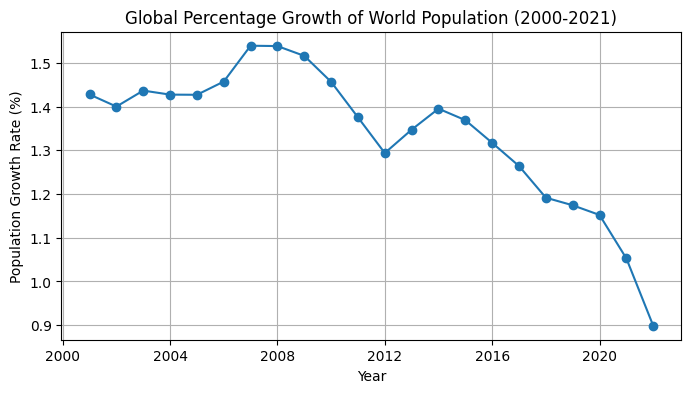

In [ ]:
#Get global population growth rate per year
growth_long_format = pd.melt(total_population_growth, id_vars=['economy'], var_name='Year', value_name='PercGrowth')
growth_long_format['Year'] = growth_long_format['Year'].str.replace('YR', '').map(lambda x: pd.to_datetime(f"{x}-12-31"))

#Group by year and calculate the mean growth rate
global_growth = growth_long_format.groupby('Year')['PercGrowth'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(global_growth['Year'], global_growth['PercGrowth'], marker='o')
plt.title('Global Percentage Growth of World Population (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Population Growth Rate (%)')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In the next block, we will perform Augmented Dickey-Fuller (ADF) test on the 'PercGrowth' column  to determine whether the time series is stationary. autolag='AIC' means that the test will automatically select the lag length that minimizes the Akaike Information Criterion, which helps to improve the test's accuracy.

Also did train-test data split. The training data consists of the first 80% of the series, while the test data consists of the remaining 20%.

In [ ]:
#ADF Test
ADF_Test = adfuller(PercentGrowth['PercGrowth'], autolag='AIC')
#print(PG_stationarityTest)
print("P-value: ", ADF_Test[1])
print("Based on ADF Test, global population growth data is actually stationary")

# Create training and test data
train_data = PercentGrowth['PercGrowth'][:round(len(PercentGrowth['PercGrowth'])*0.8)]
test_data = PercentGrowth['PercGrowth'][round(len(PercentGrowth['PercGrowth'])*0.8):]

P-value:  1.9328221748776844e-19
Based on ADF Test, global population growth data is actually stationary


The result from the Augmented Dickey-Fuller (ADF) test, a p-value of
1.9328221748776844e-19, actually indicates that data is stationary. Since your p-value is way below 0.05 (in fact, it's practically 0 when considering typical significance levels), it strongly suggests that your time series data is stationary. Therefore, you don't need to difference or transform this particular time series to make it stationary for the purposes of time series modeling - so can use AR over ARIMA


The primary goal of fitting a model is to estimate the parameters (coefficients) that best describe the relationship in the data. In an AutoRegressive (AR) model, the coefficients represent the relationship between the current value of the time series and its past values (lags). In your model, you have coefficients for the first four lags (PercGrowth.L1, L2, L3, L4), which means the model uses the past four values of PercGrowth to predict its current value.

Training data, which is historical data, provides the basis for the model to 'learn' or capture the underlying patterns and dynamics of the time series. The AR model tries to understand how past values of the series are related to its current value.

After fitting the model on training data, we will assess its performance on a
test dataset.

In [ ]:
#fit AutoRegressive (AR) model to train data
ar_model = AutoReg(train_data, lags=4).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:             PercGrowth   No. Observations:                 4682
Model:                     AutoReg(4)   Log Likelihood               -8560.992
Method:               Conditional MLE   S.D. of innovations              1.508
Date:                Tue, 05 Dec 2023   AIC                          17133.985
Time:                        18:44:37   BIC                          17172.689
Sample:                             4   HQIC                         17147.596
                                 4682                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4932      0.048     30.892      0.000       1.398       1.588
PercGrowth.L1    -0.0251      0.015     -1.717      0.086      -0.054       0.004
PercGrowth.L2    -0.0649      0.015     

PercGrowth.L1, L2, L3, L4: Coefficients of the 1st, 2nd, 3rd, and 4th lags of
PercGrowth. Based on the AR model summary, the model seems to capture some patterns in the PercGrowth time series, as indicated by the significant coefficients (especially for the 2nd lag).


*   PercGrowth.L1: Coefficient for the first lag (previous value). It shows how much the previous value of PercGrowth influences the current value.
*   PercGrowth.L2: Coefficient for the second lag (value before the previous one). It indicates the influence of the value two time periods ago on the current value.
*   PercGrowth.L3 and PercGrowth.L4: Similar interpretations for the third and fourth previous values, respectively.

The p-values (listed under P>|z|) assess the significance of each coefficient. They test the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (<0.05) suggests that the corresponding lag is statistically significant. This means that this particular past value (lag) is a good predictor of the current value. For example, PercGrowth.L2 has a p-value of 0.000 which is significant, this indicates that the second lag is a significant predictor of the current value of PercGrowth.

Modulus: A stable AR model requires all roots to lie outside the unit circle in the complex plane. Here, the modulus of all roots is greater than 1, suggesting that the model is stable.

The model summary shows that at least some of the lagged terms (specifically the second lag in your case) are important predictors for the current value of PercGrowth. This is a strong indication that the time series has an inherent auto-correlation structure that the AR model is successfully leveraging for forecasting.

In [ ]:
#make prediction and show it on previously generated global population growth rate plot.

#generate predictions for the next 5 years
num_yrs_to_predict = 2025 - global_growth['Year'].dt.year.max()
pred = ar_model.predict(start=len(train_data), end=len(train_data) + num_yrs_to_predict, dynamic=False)

# Prepare a new index for the predictions
pred_years = pd.date_range(start=global_growth['Year'].iloc[-1] + pd.DateOffset(years=1), periods=len(pred), freq='A-DEC')
pred.index = pred_years

#get the last actual data point (for 2021)
last_actual_data = global_growth[global_growth['Year'] == '2021-12-31']['PercGrowth']
last_actual_data_series = pd.Series(last_actual_data.values, index=[global_growth['Year'].iloc[-1]])

#combine the last actual data point with the predictions
combined_pred = pd.concat([last_actual_data_series, pred])
combined_pred

2021-12-31    0.898738
2022-12-31    1.240563
2023-12-31    1.291704
2024-12-31    1.454731
2025-12-31    1.434511
2026-12-31    1.391921
dtype: float64

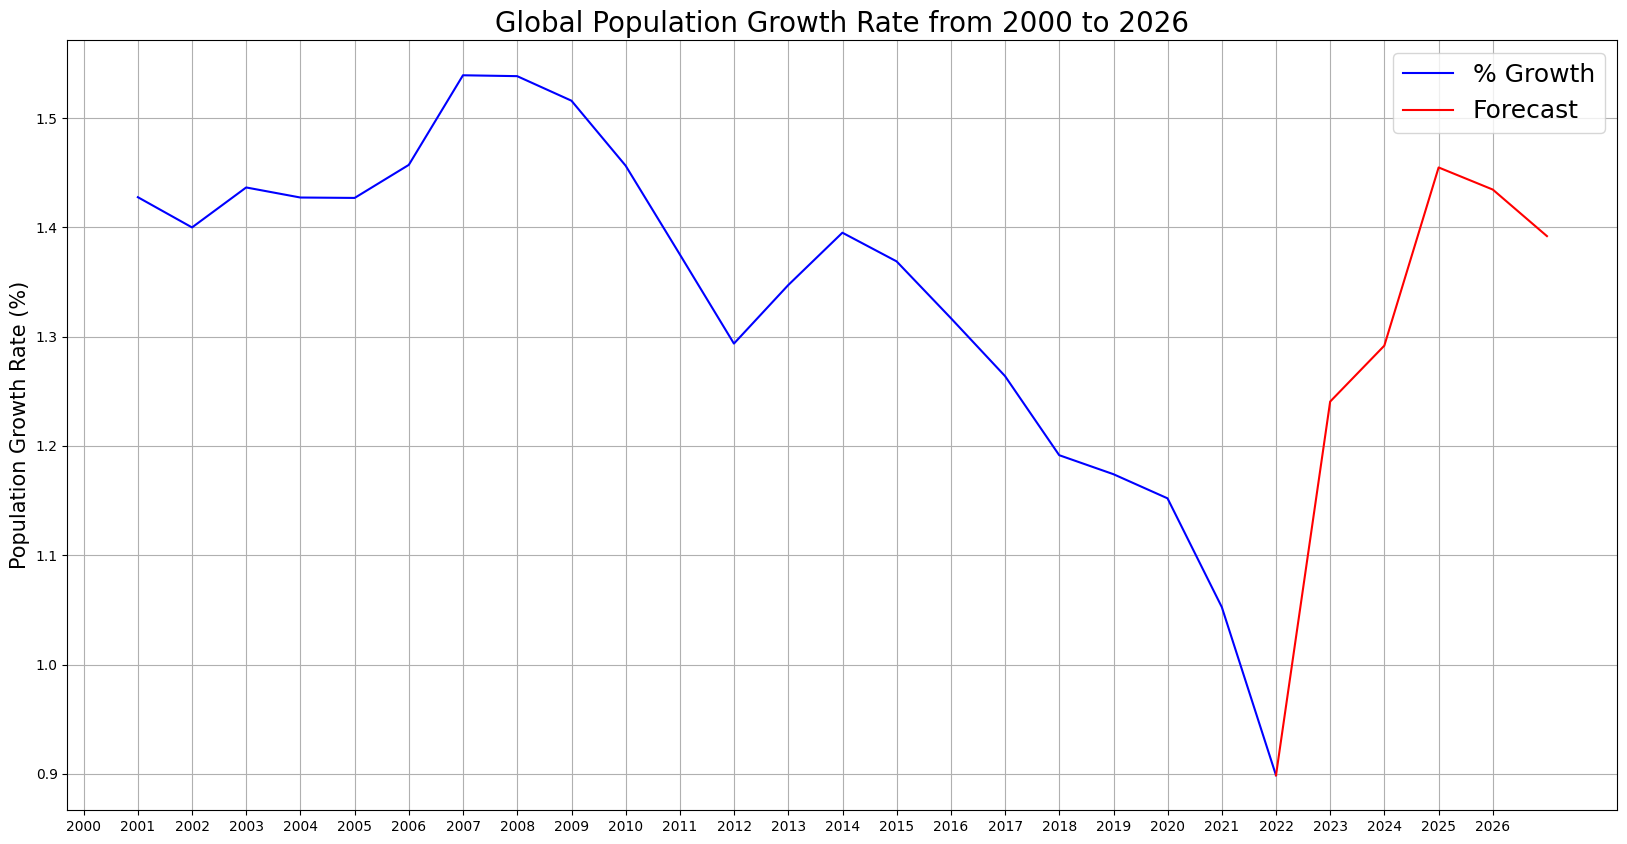

In [ ]:
#plot actual data
plt.figure(figsize=[20,10])
plt.plot(global_growth['Year'], global_growth['PercGrowth'], label="% Growth", color='blue')

#plot predictions
plt.plot(combined_pred.index, combined_pred, color='red', label="Forecast")
#adjust x-ticks to show years from 2000 to 2026
plt.xticks(pd.date_range(start='2000-01-01', end='2026-01-01', freq='YS'), [year.strftime('%Y') for year in pd.date_range(start='2000-01-01', end='2026-01-01', freq='YS')])
plt.ylabel("Population Growth Rate (%)", fontsize=15)
plt.title("Global Population Growth Rate from 2000 to 2026", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

The predicted rates for 2022-2026 show an increase compared to the actual rate in 2021. This suggests a rebound or acceleration in global population growth after the significant dip in 2021. The actual rate for 2021 is significantly lower than previous years, which might reflect unique circumstances impacting global population growth in that year, such as the COVID-19 pandemic. The model predicts a recovery from this low point.

The predicted rates from 2022 onwards are more aligned with the historical rates observed in the early 2000s, suggesting a return to the earlier population growth dynamics.

This fluctuating pattern in 2025 and 2026 could be indicative of varying global demographic trends, economic conditions, or other factors affecting population growth.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

#generate predictions for the test set
#ensure the predicted range aligns with the test data length
test_pred = ar_model.predict(start=len(train_data),
                             end=len(train_data)+len(test_data)-1, dynamic=False)

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, test_pred))
print(f"RMSE: {rmse}")

RMSE: 1.2820398727348068


Considering that data's range is 0.9 to 1.6, an RMSE of 1.282 is quite significant. This implies that the model's predictions can be off by a large portion of the entire range of the data. A high RMSE relative to the range of the data suggests that the model may not be very accurate in predicting the population growth rate. This could be due to the model not capturing all the underlying patterns in the data, lack of training data, or inherent unpredictability in the data itself.

#Time Series: Forecasting population change in the next 5 years using AutoRegressive (AR)

In [ ]:
#convert the data into TimeSeries
temp = total_population.iloc[:, :-2]
PopChange = pd.melt(temp, id_vars=['economy'], var_name='Year', value_name='PopChange')
PopChange['Year'] = PopChange['Year'].str.replace('YR', '').map(lambda x: pd.to_datetime(f"{x}-12-31"))
PopChange.head(5)

,economy,Year,PopChange
0,ABW,2000-12-31,89101
1,AFG,2000-12-31,19542982
2,AGO,2000-12-31,16394062
3,ALB,2000-12-31,3089027
4,AND,2000-12-31,66097


In [ ]:
#ADF Test
ADF_Test = adfuller(PopChange['PopChange'], autolag='AIC')
#print(PG_stationarityTest)
print("P-value: ", ADF_Test[1])
print("Based on ADF Test, global population change data is actually stationary")

P-value:  7.902148916518115e-29
Based on ADF Test, global population change data is actually stationary


In [ ]:
# Create training and test data
train_data2 = PopChange['PopChange'][:round(len(PopChange['PopChange'])*0.8)]
test_data2 = PopChange['PopChange'][round(len(PopChange['PopChange'])*0.8):]

In [ ]:
#fit AutoRegressive (AR) model to train data
ar_model2 = AutoReg(train_data2, lags=4).fit()
print(ar_model2.summary())

                            AutoReg Model Results                             
Dep. Variable:              PopChange   No. Observations:                 3802
Model:                     AutoReg(4)   Log Likelihood              -76268.168
Method:               Conditional MLE   S.D. of innovations      127318313.076
Date:                Tue, 05 Dec 2023   AIC                         152548.335
Time:                        18:45:00   BIC                         152585.789
Sample:                             4   HQIC                        152561.646
                                 3802                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.048e+07    2.3e+06     13.268      0.000     2.6e+07     3.5e+07
PopChange.L1    -0.0284      0.016     -1.751      0.080      -0.060       0.003
PopChange.L2     0.0830      0.016      5.11

We previously derived yearly global population sum - pop_years_agg

In [ ]:
#for original yearly global population sum data, convert series to dataframe
pop_df = pop_years_agg.reset_index()
pop_df.columns = ['Year', 'PopChange']
pop_df['Year'] = pop_df['Year'].str.replace('YR', '').map(lambda x: pd.to_datetime(f"{x}-12-31"))
pop_df

,Year,PopChange
0,2000-12-31,6122003627
1,2001-12-31,6203862506
2,2002-12-31,6285536315
3,2003-12-31,6366759902
4,2004-12-31,6448134558
5,2005-12-31,6529827126
6,2006-12-31,6612143746
7,2007-12-31,6694823219
8,2008-12-31,6778561282
9,2009-12-31,6862624719


In [ ]:
#generate predictions for the next 5 years
num_yrs_to_predict2 = 2025 - pop_df['Year'].dt.year.max()
pred2 = ar_model2.predict(start=len(train_data2), end=len(train_data2) + num_yrs_to_predict2, dynamic=False)

# Prepare a new index for the predictions
pred_years2 = pd.date_range(start=pop_df['Year'].iloc[-1] + pd.DateOffset(years=1), periods=len(pred2), freq='A-DEC')
pred2.index = pred_years2

#get the last actual data point (for 2021)
last_actual_data2 = pop_df[pop_df['Year'] == '2021-12-31']['PopChange']
last_actual_data_series2 = pd.Series(last_actual_data2.values, index=[pop_df['Year'].iloc[-1]])

#combine the last actual data point with the predictions
combined_pred2 = pd.concat([last_actual_data_series2, pred2])
combined_pred2

2021-12-31    7.864501e+09
2022-12-31    2.933388e+07
2023-12-31    3.337306e+07
2024-12-31    3.293884e+07
2025-12-31    3.117447e+07
2026-12-31    3.200877e+07
dtype: float64

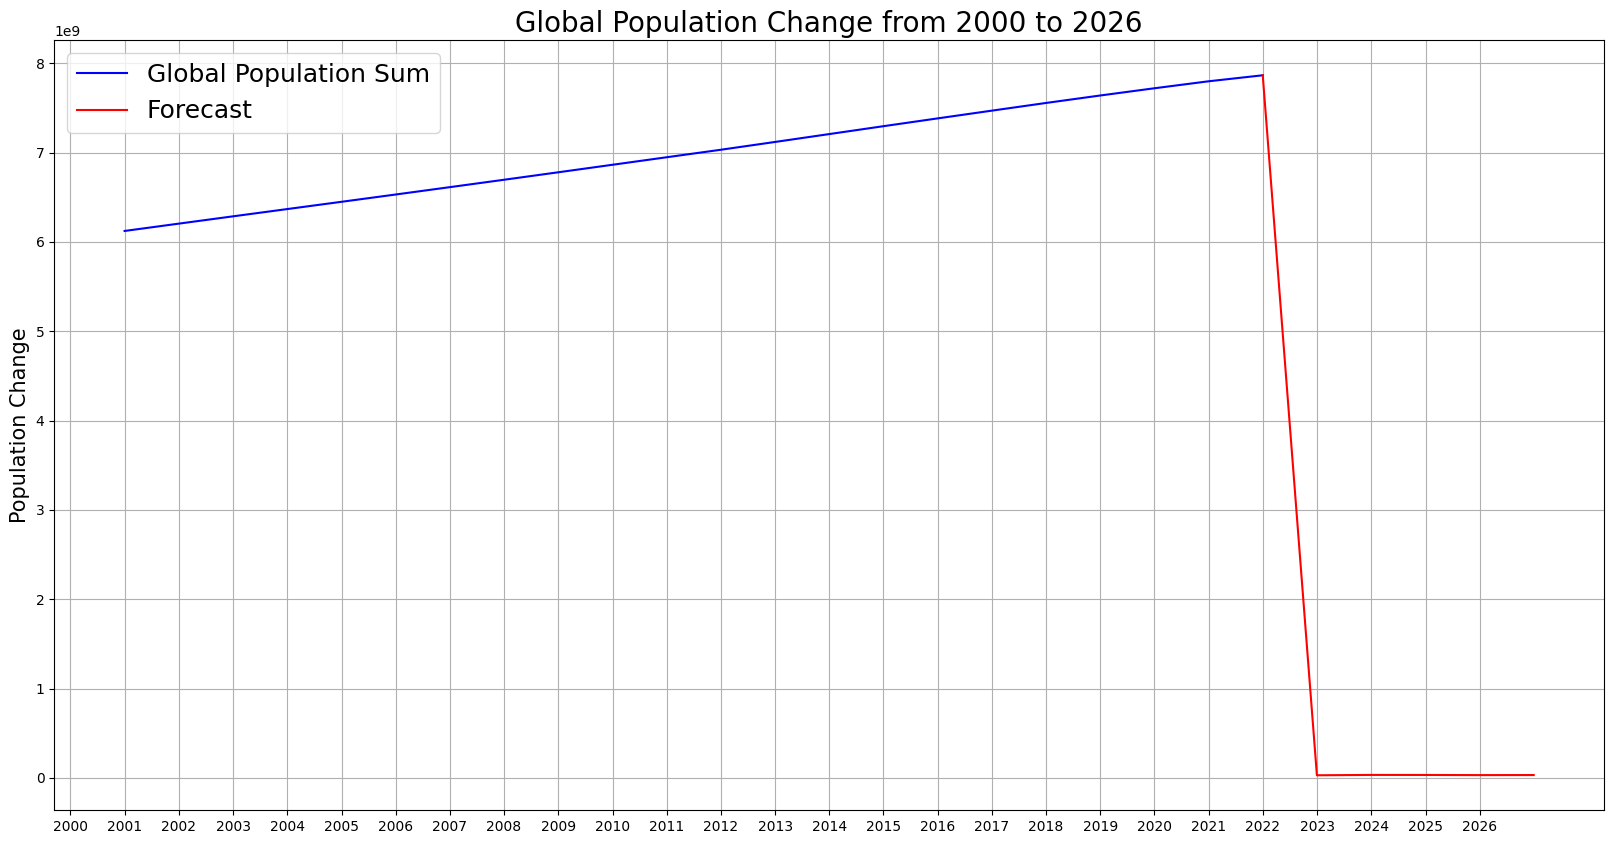

In [ ]:
#plot actual data
plt.figure(figsize=[20,10])
plt.plot(pop_df['Year'], pop_df['PopChange'], label="Global Population Sum", color='blue')

#plot predictions
plt.plot(combined_pred2.index, combined_pred2, color='red', label="Forecast")
#adjust x-ticks to show years from 2000 to 2026
plt.xticks(pd.date_range(start='2000-01-01', end='2026-01-01', freq='YS'), [year.strftime('%Y') for year in pd.date_range(start='2000-01-01', end='2026-01-01', freq='YS')])
plt.ylabel("Population Change", fontsize=15)
plt.title("Global Population Change from 2000 to 2026", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()


Evaluate using RMSE

In [ ]:
#generate predictions for the test set, ensure the predicted range aligns with the test data length
test_pred2 = ar_model.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)-1, dynamic=False)

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data2, test_pred2))
print(f"RMSE: {rmse}")

RMSE: 138206820.95371118
